# MAD Competition

Maximum differentiation (MAD) competition comes from a paper published in 2008 by Zhou Wang and Eero Simoncelli ([reprint](https://www.cns.nyu.edu/pub/lcv/wang08-preprint.pdf) from LCV website). In MAD Competition, the goal is to efficiently compare two competing perceptual metrics. Like the inputs for all synthesis methods in `plenoptic`, metrics operate on images and produce predictions related to perception. As originally conceived, the metrics in MAD competition are either similarity (e.g., SSIM) or distance (e.g., MSE) metrics: they take two images and return a scalar value that gives a perceptual similarity or distance. For distance metrics, the smaller this number is, the more perceptually similar the metric predicts they will be; for similarity metrics, the larger the number is, the more percpetually similar.

In `plenoptic`, a single instantiation of `MADCompetition` synthesizes a single image, holding the `fixed_metric` constant while either maximizing or minimizing `synthesis_metric`, depending on the value of `synthesis_target`. A full set of MAD competition images consists of four images, maximizing and minimizing each of the two metrics. For each pair of images, one metric predicts they are perceptually identical, while the other metric predicts they are as dissimilar as possible. This set therefore allows us to efficiently compare the two models.

In the paper, these images are generated by manually computing the gradients, projecting one gradient out of the other, and repeating until convergence was reached. This doesn't work as well in the general case, so we instead optimize using the following objective function:

$$t L_1(x, \hat{x}) + \lambda_1 [L_2(x, x+\epsilon) - L_2(x, \hat{x})]^2 + \lambda_2 \mathcal{B}(\hat{x})$$

where $t$ is 1 if `mad.synthesis_target` is `'min'` and -1 if it's `'max'`, $L_1$ is `mad.synthesis_metric`, $L_2$ is `mad.fixed_metric`, $x$ is `mad.reference_signal`, $\hat{x}$ is `mad.synthesized_signal`, $\epsilon$ is the initial noise, $\mathcal{B}$ is the quadratic bound penalty, $\lambda_1$ is `mad.metric_tradeoff_lambda` and $\lambda_2$ is `mad.range_penalty_lambda`.


That's the general idea, now let's explore how to use the `MADCompetition` class for generating these images

In [1]:
import plenoptic as po
import imageio
import torch
import pyrtools as pt
import matplotlib.pyplot as plt
import numpy as np
import warnings

%load_ext autoreload
%autoreload 2

/home/billbrod/miniconda3/envs/plenoptic/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Basic usage

As with all our synthesis methods, we start by grabbing a target image and initalizing our models.

/home/billbrod/Documents/plenoptic/plenoptic/tools/data.py:115: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  images = torch.tensor(images, dtype=torch.float32)


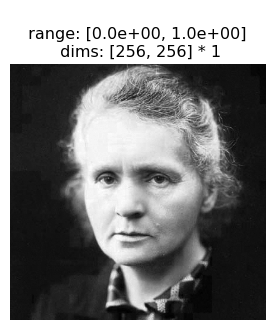

In [2]:
img = po.tools.data.load_images(['../data/256/curie.pgm'])
po.imshow(img);

To start, we'll demonstrate MAD competition as described in the paper, using two metrics: SSIM (structural similarity index, described [here](https://www.cns.nyu.edu/pub/lcv/wang03-preprint.pdf)) and MSE (mean-squared error), implementations for both of which are found in `plenoptic.metric`. We use the weighted version of SSIM described in the MAD Competition paper, hence the keyword argumentpassed to `ssim` below. Note also that we use `1-SSIM`: SSIM measures similarity (so that 0 means completely different and 1 means identical), but `MADCompetition` expects [metrics](https://en.wikipedia.org/wiki/Metric_(mathematics)), which return 0 if and only if the two inputs are identical.

In [3]:
model1 = lambda *args: 1-po.metric.ssim(*args, weighted=True, pad='reflect')
model2 = po.metric.mse

To intitialize the method, we only need to specify the target image (as a 4d tensor, as returned by `load_images`), the two metrics, and the target. To start, we will hold MSE constant, while minimizing SSIM.

Note that, as described in the first block, we synthesize these images by optimizing a tradeoff between the loss of these two metrics, weighted by the `metric_tradeoff_lambda`. If that argument is unset, we default to something we think is reasonable, but in practice, we often need to experiment and find the appropriate value, trying out different values until the fixed metric stays constant while the synthesis metric decreases or increases as desired. 

In [4]:
mad = po.synth.MADCompetition(img, synthesis_metric=model1, fixed_metric=model2, synthesis_target='min', initial_noise=.04,
                              metric_tradeoff_lambda=10000)

/home/billbrod/miniconda3/envs/plenoptic/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


At the most basic, all we need to do is call `mad.synthesize()`. Let's do that and then view the outcome. There are several additional arguments to `synthesize()` but none are required.

 88%|▉| 177/200 [00:32<00:04,  5.52it/s, loss=1.6560e-03, learning_rate=0.01, gradient_norm=6.3078e-05, pixel_change


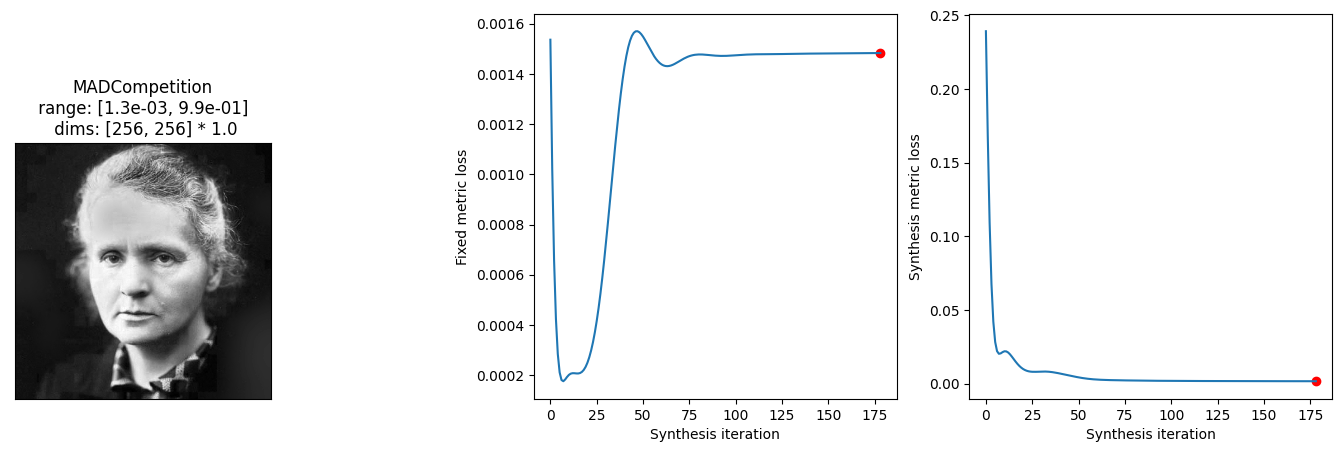

In [5]:
with warnings.catch_warnings():
    # we suppress the warning telling us that our image falls outside of the (0, 1) range,
    # which will happen briefly during synthesis.
    warnings.simplefilter('ignore')
    mad.synthesize(max_iter=200)
fig = po.synth.mad_competition.plot_synthesis_status(mad)

We can see from the loss plot that SSIM's loss has decreased, while MSE's, other than a brief dip in the beginning, is staying roughly constant. 

As described in the opening paragraph, a full set of MAD competition synthesized images consists of four images. In order to create the other images, we must create a new instance of `MADCompetition`. Let's do that for the other images now:

100%|█| 200/200 [00:32<00:00,  6.10it/s, loss=3.4502e-01, learning_rate=0.01, gradient_norm=1.8585e-03, pixel_change


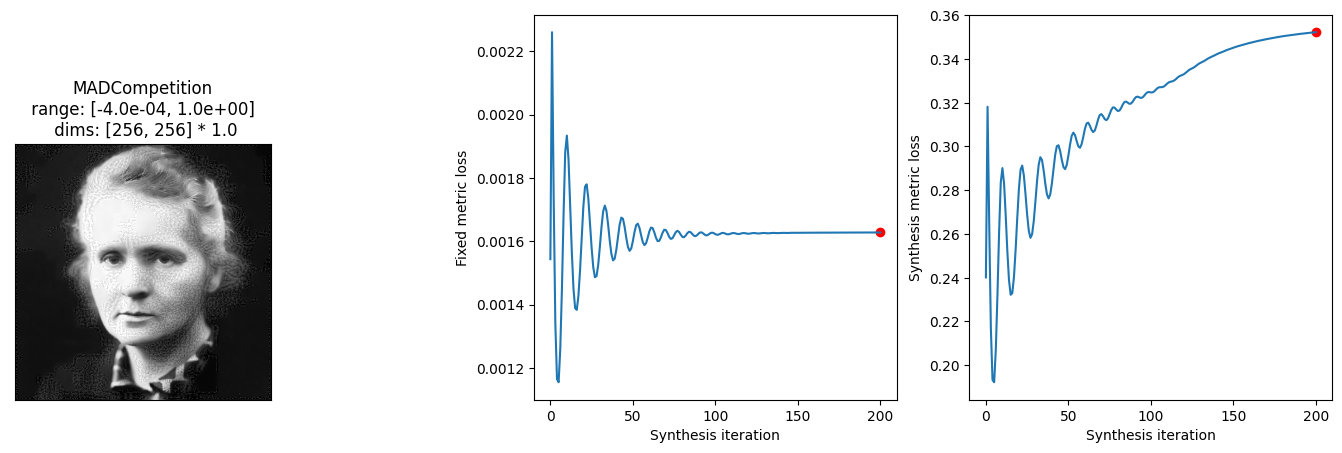

In [6]:
mad_ssim_max = po.synth.MADCompetition(img, synthesis_metric=model1, fixed_metric=model2, synthesis_target='max', initial_noise=.04,
                                      metric_tradeoff_lambda=1e6)
with warnings.catch_warnings():
    # we suppress the warning telling us that our image falls outside of the (0, 1) range,
    # which will happen briefly during synthesis.
    warnings.simplefilter('ignore')
    mad_ssim_max.synthesize(max_iter=200)
fig = po.synth.mad_competition.plot_synthesis_status(mad_ssim_max)

We're making progress, but it doesn't look like `SSIM` has quite saturated. Let's see if we can make more progress!

To continue synthesis, we can simply call `mad.synthesize()` again (`optimizer` and `scheduler` will both need to be `None`, the default, so we reuse the ones from the initial call), and we then pick up right where we left off.

100%|█| 300/300 [00:39<00:00,  7.58it/s, loss=3.5074e-01, learning_rate=0.01, gradient_norm=2.9395e-04, pixel_change


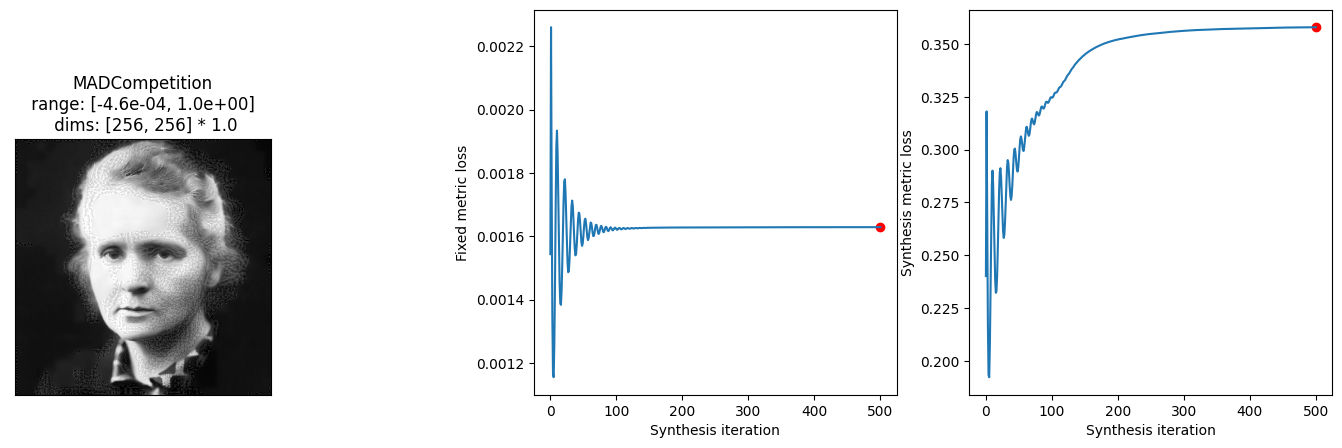

In [7]:
with warnings.catch_warnings():
    # we suppress the warning telling us that our image falls outside of the (0, 1) range,
    # which will happen briefly during synthesis.
    warnings.simplefilter('ignore')
    mad_ssim_max.synthesize(max_iter=300)
fig = po.synth.mad_competition.plot_synthesis_status(mad_ssim_max)

Next, let's hold SSIM constant while changing MSE. This will require changing the `metric_tradeoff_lambda`. We also set `stop_criterion` explicitly, to a smaller value, to allow the synthesis to continue longer.

100%|█| 400/400 [00:52<00:00,  7.65it/s, loss=1.0053e-03, learning_rate=0.01, gradient_norm=4.9208e-05, pixel_change


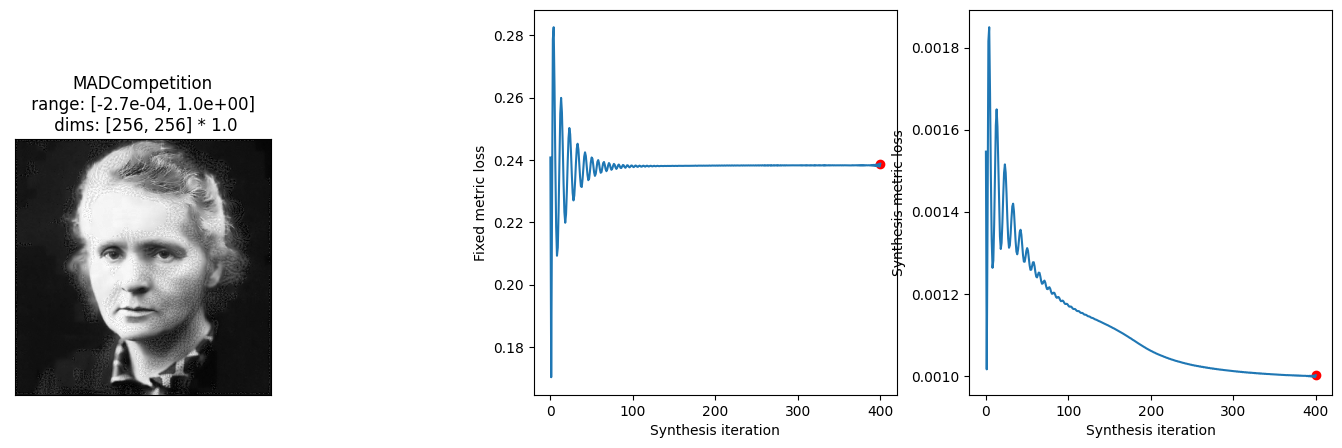

In [8]:
mad_mse_min = po.synth.MADCompetition(img, synthesis_metric=model2, fixed_metric=model1, synthesis_target='min', initial_noise=.04, 
                                      metric_tradeoff_lambda=1)
with warnings.catch_warnings():
    # we suppress the warning telling us that our image falls outside of the (0, 1) range,
    # which will happen briefly during synthesis.
    warnings.simplefilter('ignore')
    mad_mse_min.synthesize(max_iter=400, stop_criterion=1e-6)
fig = po.synth.mad_competition.plot_synthesis_status(mad_mse_min)

Maximizing MSE has the same issue; after playing around with it, we use a slightly larger `metric_tradeoff_lambda` than above.

In general, finding an appropriate hyperparameter here will require some consideration on the part of the user and some testing of different values.

100%|█| 200/200 [00:24<00:00,  8.13it/s, loss=5.9114e-03, learning_rate=0.01, gradient_norm=5.7348e-03, pixel_change


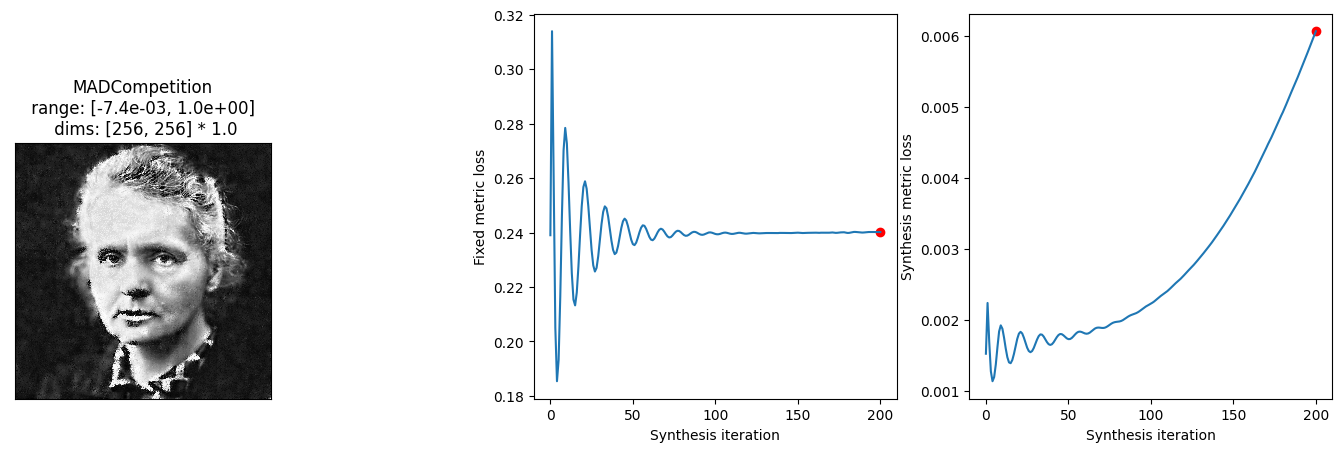

In [9]:
mad_mse_max = po.synth.MADCompetition(img, synthesis_metric=model2, fixed_metric=model1, synthesis_target='max', initial_noise=.04, 
                                      metric_tradeoff_lambda=10)
with warnings.catch_warnings():
    # we suppress the warning telling us that our image falls outside of the (0, 1) range,
    # which will happen briefly during synthesis.
    warnings.simplefilter('ignore')
    mad_mse_max.synthesize(max_iter=200, stop_criterion=1e-6)
fig = po.synth.mad_competition.plot_synthesis_status(mad_mse_max)

The image above has increased the local contrast in different parts of the image, which SSIM generally doesn't care about but MSE does. For example, the collar, which in the original image is two different shades of gray, here is black and white. Similarly with the eyes, hair, and lips.

While above we displayed the synthesized image and the loss together, these are actually handled by two helper functions and can be called separately, as axes-level figures. They have additional arguments that may be worth playing around with:

<AxesSubplot: xlabel='Synthesis iteration', ylabel='Synthesis metric loss'>

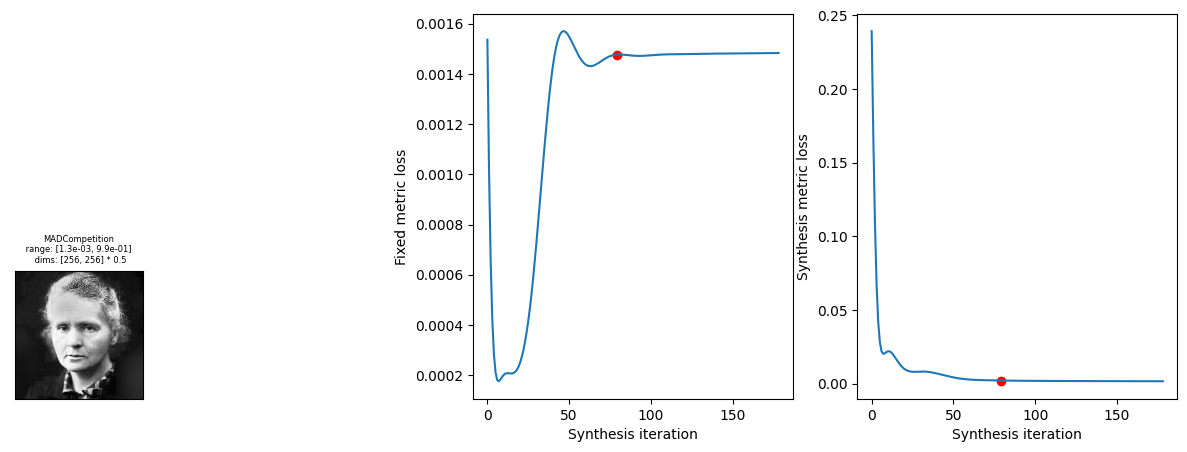

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 2]})
po.synth.mad_competition.display_synthesized_signal(mad, ax=axes[0], zoom=.5)
po.synth.mad_competition.plot_loss(mad, axes=axes[1], iteration=-100)

We also provide helper functions to plot a full set of MAD images together, either displaying all their synthesized images or their losses (note that we're calling our metric `SDSIM` because it's now the structural *dis*-similarity):

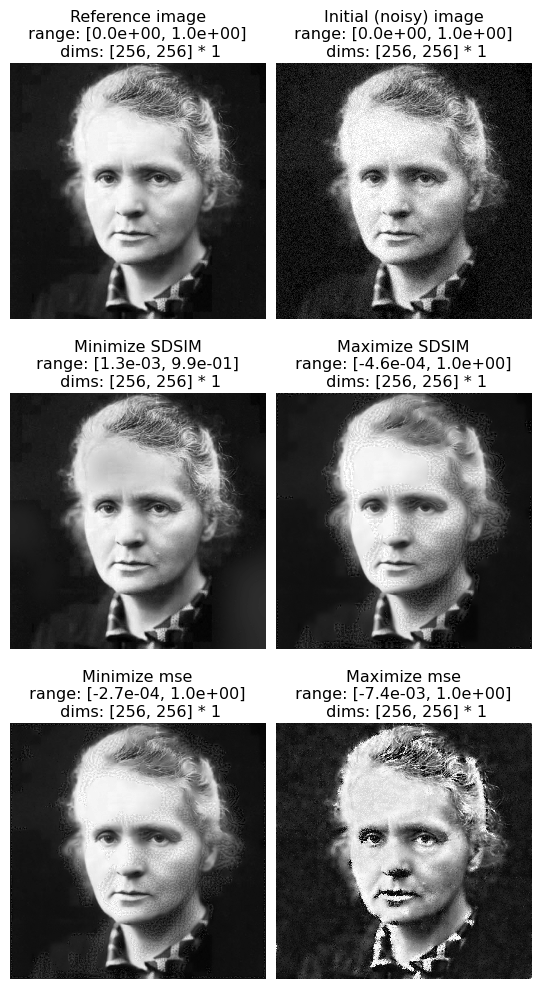

In [11]:
po.synth.mad_competition.display_synthesized_signal_all(mad, mad_mse_min, mad_ssim_max, mad_mse_max, 'SDSIM');

The top row shows the reference and initial images, our picture of Marie Curie and that same image plus some normally-distributed noise. The next row of images has the same MSE as the right image in the top row (when compared against the reference image), but different SDSIM values. The left image has the lowest SDSIM and is thus considered the best image, while the right image has the highest SDSIM and is thus considered the worst. The next row of images has the same SDSIM as the right image in the top, but different MSE values. The left has the lowest MSE and is thus considered the best, while the right has highest MSE and is thus considered the worst.

So MSE considers the first three images to be approximately equivalent in quality, while SDSIM considers the first image and the last two to be equivalent.

From the following plot, we can see that we generally manage to hold the fixed metric constant (dashed line for SDSIM in the right plot, solid line for MSE in the left) while increasing the target metric.

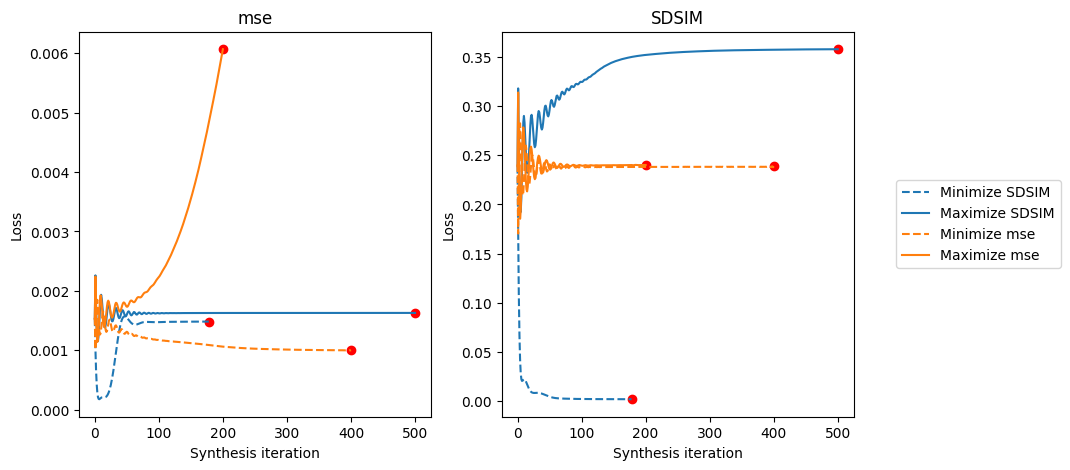

In [12]:
po.synth.mad_competition.plot_loss_all(mad, mad_mse_min, mad_ssim_max, mad_mse_max, 'SDSIM');